**Table of contents**<a id='toc0_'></a>    
- [Daily Gas Demand Ireland](#toc1_)    
  - [Dataset description](#toc1_1_)    
  - [Data Cleaning and Exploration.](#toc1_2_)    
    - [Data Visualization.](#toc1_2_1_)    
      - [Gas Consumption Across Economic Sectors for all years.](#toc1_2_1_1_)    
      - [Gas Consumption by Economic Sector in the Republic of Ireland for all years.](#toc1_2_1_2_)    
      - [Comparison of Gas Consumption During the Second and Third Lockdown Periods with the Corresponding Period from the Previous Year.](#toc1_2_1_3_)    
        - [Conclusion:](#toc1_2_1_3_1_)    
  - [Correlation](#toc1_3_)    
  - [Regression model](#toc1_4_)    
    - [Visualization of Polynomial Regression with Seaborn.](#toc1_4_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Daily Gas Demand Ireland](#toc0_)

## <a id='toc1_1_'></a>[Dataset description](#toc0_)

This dataset provides daily gas demand data for Ireland, covering various sectors and categories. The metric for the data is **GWh** (Gigawatt-hours) The columns represent:

**Date**: The date for each entry in the dataset.

**Daily Metered**: Gas consumption by large consumers who are metered on a daily basis (consume over 5.55 GWh annually).

**Non Daily Metered (NDM)**: Gas consumption by small to medium businesses and residential properties, which typically consume less than 5.55 GWh annually.

**Large Daily Metered (LDM) non Power Gen:** Gas consumption by large industrial users (excluding power generation), such as pharmaceutical, agri-food, and manufacturing sectors (consume over 5.55 GWh annually).

**Power Generation:** Gas used in gas-fired thermal power generation, which fluctuates depending on electricity demand and renewable generation conditions.

**Total ROI demand:** The total gas demand in the Republic of Ireland, combining all the above sectors.

In [382]:
#import libraries

import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

## <a id='toc1_2_'></a>[Data Cleaning and Exploration.](#toc0_)

In [383]:
data = pd.read_csv("https://www.gasnetworks.ie/corporate/open-data/2024-Q3-Daily-Gas-Demand.csv")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2465 entries, 0 to 2464
Data columns (total 6 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Date                                     2465 non-null   object 
 1   Daily Metered                            2465 non-null   float64
 2   Non Daily Metered (NDM)                  2465 non-null   float64
 3   Large Daily Metered (LDM) non Power Gen  2465 non-null   float64
 4   Power Generation                         2465 non-null   float64
 5   Total ROI demand                         2465 non-null   float64
dtypes: float64(5), object(1)
memory usage: 115.7+ KB


,Date,Daily Metered,Non Daily Metered (NDM),Large Daily Metered (LDM) non Power Gen,Power Generation,Total ROI demand
0,01/01/2018,7.251362,55.409405,9.494423,57.062501,129.217691
1,02/01/2018,9.541429,57.607694,10.575758,54.855833,132.580714
2,03/01/2018,10.481540,60.505595,12.308507,69.217500,152.513142
3,04/01/2018,10.576218,59.123724,13.310019,96.651666,179.661627
4,05/01/2018,10.683822,62.322325,13.327011,100.158333,186.491491


- The dataset contains no missing values.<br>
- The data in the **Date** column is in an object format and needs to be converted to a datetime format.<br>
- All other columns contain data in float format.

In [384]:
# Renaming columns:

# Daily Metered = `l_business`
# Non-Daily Metered (NDM) = `xs_business_houses`
# Large Daily Metered (LDM) non Power Gen = `xl_business`
# Power Generation = `power_gen`
# Total ROI demand = `total`

data.columns = ['date','l_business','xs_business_houses','xl_business','power_gen','total']

In [385]:
# Rounding the data to 2 decimal places
data = data.round(2)

# Formatting the date column
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y')

# Statistical summary of the data
data.describe()

,date,l_business,xs_business_houses,xl_business,power_gen,total
count,2465,2465.000000,2465.000000,2465.000000,2465.000000,2465.000000
mean,2021-05-17 00:00:00,9.039943,31.291124,16.196114,95.585168,152.112373
min,2018-01-01 00:00:00,4.380000,6.530000,5.120000,36.550000,71.690000
25%,2019-09-09 00:00:00,7.700000,12.650000,14.900000,78.220000,132.720000
50%,2021-05-17 00:00:00,8.810000,28.980000,16.420000,96.610000,151.470000
75%,2023-01-23 00:00:00,10.480000,47.590000,17.800000,113.100000,170.450000
max,2024-09-30 00:00:00,14.030000,97.230000,21.970000,161.180000,261.450000
std,NaN,1.863845,18.894646,2.390391,23.975290,29.298692


* **Time Span:** The dataset spans from January 1, 2018, to September 30, 2024, covering daily gas demand data for Ireland over 2,465 days.

* **Small business and households**(`xs_business_houses`): demonstrates high variability (std: 18.89 GWh).

* **Power Generation plants** (`power_gen`) also has significant variation (std: 23.98 GWh).

* **Large business, manufacturing, and industrial sectors** (`l_business` and `xl_business`) show more stable gas demand because many of these sites have consistent gas usage throughout the year.

### <a id='toc1_2_1_'></a>[Data Visualization.](#toc0_)
#### <a id='toc1_2_1_1_'></a>[Gas Consumption Across Economic Sectors for all years.](#toc0_)

Ref.[distance between title and plot](https://stackoverflow.com/questions/16419670/increase-distance-between-title-and-plot-in-matplolib)

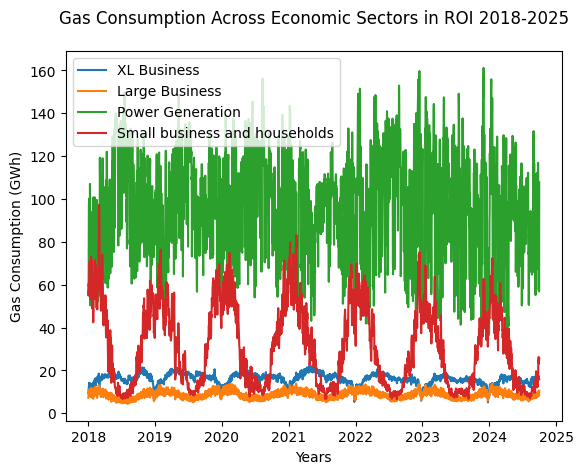

In [386]:
fig,ax =plt.subplots()
ax.plot(data['date'],data['xl_business'], label='XL Business')
ax.plot(data['date'],data['l_business'], label='Large Business')
ax.plot(data['date'],data['power_gen'], label='Power Generation')
ax.plot(data['date'],data['xs_business_houses'], label='Small business and households')
ax.set_xlabel("Years")
ax.set_ylabel("Gas Consumption (GWh)")
ax.legend()

# `pad=20` increases the distance between the title and the plot
plt.title("Gas Consumption Across Economic Sectors in ROI 2018-2025", pad=20)
plt.show()

#### <a id='toc1_2_1_2_'></a>[Gas Consumption by Economic Sector in the Republic of Ireland for all years.](#toc0_)

In [387]:
#Filtering data
consumers_share = data[['l_business','xl_business','power_gen','xs_business_houses']].sum()
consumers_share

l_business             22283.46
xl_business            39923.42
power_gen             235617.44
xs_business_houses     77132.62
dtype: float64

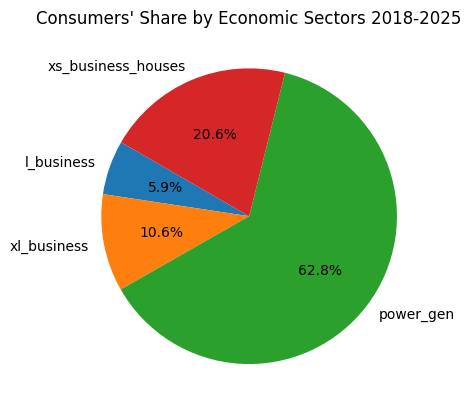

In [388]:
# Pie chart
labels= consumers_share.index
share = consumers_share.values

plt.figure()
plt.pie(share,labels=labels, autopct='%1.1f%%',startangle=150)
plt.title("Consumers' Share by Economic Sectors 2018-2025")
plt.show()

#### <a id='toc1_2_1_3_'></a>[Comparison of Gas Consumption During the Second and Third Lockdown Periods with the Corresponding Period from the Previous Year.](#toc0_)
**Second and Third Lockdowns: 19 October 2020 - 10 March 2021.**

Ref.:[COVID-19 pandemic in the Republic of Ireland](https://en.wikipedia.org/wiki/COVID-19_pandemic_in_the_Republic_of_Ireland)

I want to explore if COVID-19 and the Lockdown period has affected gas consumption patterns in the Republic of Ireland (ROI). The closure of businesses and the shift to working from home could have changed how people use gas compared to the same period before the pandemic.

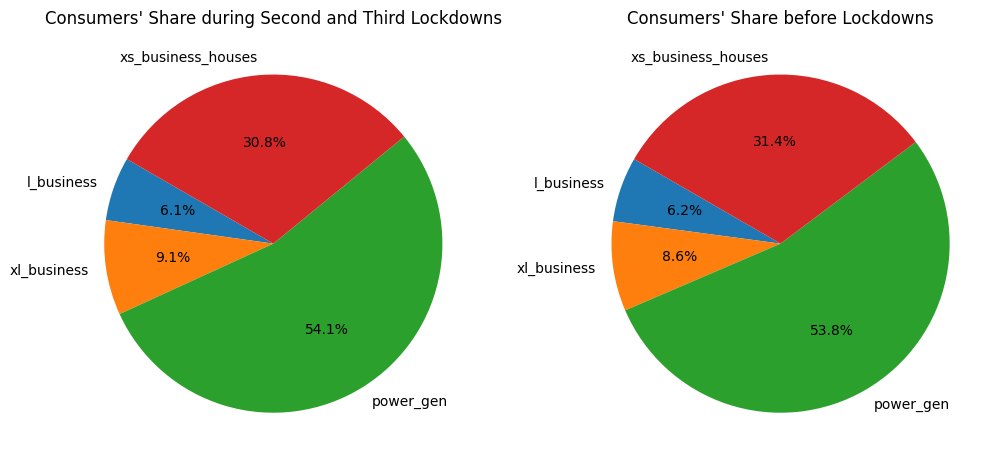

In [389]:
#filtering data for lockdown and for the same period one year early
lockdown = data[(data['date'] >= '2020-10-19') & (data['date']<= '2021-03-10')]
year_early_lockdown = data[(data['date'] >= '2019-10-19') & (data['date']<= '2020-03-10')]

# Lockdown data for pie chart
lockdown_shares = lockdown[['l_business','xl_business','power_gen','xs_business_houses']].mean()
labels= lockdown_shares.index
shares = lockdown_shares.values

# Data for pie chart before Lockdown
before_lockdown_shares = year_early_lockdown[['l_business','xl_business','power_gen','xs_business_houses']].mean()
labels_= before_lockdown_shares.index
shares_ = before_lockdown_shares.values

# Pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# lockdowns
ax1.pie(shares,labels=labels, autopct='%1.1f%%',startangle=150)
ax1.set_title("Consumers' Share during Second and Third Lockdowns")

# Before lockdowns
ax2.pie(shares_,labels=labels_, autopct='%1.1f%%',startangle=150)
ax2.set_title("Consumers' Share before Lockdowns")

plt.show()

In [390]:
# In absolute values
print(year_early_lockdown.mean())
print(lockdown.mean())

date                  2019-12-29 12:00:00
l_business                      10.771806
xs_business_houses                54.4425
xl_business                     14.868542
power_gen                       93.279444
total                          173.361944
dtype: object
date                  2020-12-29 00:00:00
l_business                       10.50965
xs_business_houses              52.922657
xl_business                     15.603077
power_gen                       93.043636
total                          172.079231
dtype: object


##### <a id='toc1_2_1_3_1_'></a>[Conclusion:](#toc0_)
The comparison of mean gas consumption during the second and third lockdown periods with the corresponding periods one year prior reveals only minor differences across the sectors. 

* Extra Large Business (XL Business): Consumption increased from 14.87 GWh to 15.60 GWh, indicating potential resilience or increased demand in this sector.
* Large Business (L Business): Consumption decreased slightly from 10.77 GWh to 10.51 GWh.
* Small Business and Households (XS Business Houses): Consumption dropped modestly from 54.44 GWh to 52.92 GWh, likely reflecting reduced activity.

These results suggest that while gas consumption patterns were slightly changed during lockdown periods, the overall impact on demand was relatively minor. 


## <a id='toc1_3_'></a>[Correlation](#toc0_)

According to the plot "Gas Consumption Across Economic Sectors in ROI 2018-2025," the correlation between month and gas consumption is most evident in the small business and household sectors.<br> In contrast, large and XL businesses demonstrates a weaker relationship between these variables.<br> Similarly, the power generation sector does not display a noticeable tendency for monthly variations in gas consumption.

I am going to calculate a correlation matrix to check if there are relationships between gas consumption across different economic sectors.

In [391]:
correlation_matrix = data.corr()
correlation_matrix

,date,l_business,xs_business_houses,xl_business,power_gen,total
date,1.000000,0.007718,-0.196658,-0.255614,-0.078131,-0.211121
l_business,0.007718,1.000000,0.782938,0.001400,0.043338,0.604109
xs_business_houses,-0.196658,0.782938,1.000000,-0.299874,-0.152493,0.545451
xl_business,-0.255614,0.001400,-0.299874,1.000000,0.206108,0.056946
power_gen,-0.078131,0.043338,-0.152493,0.206108,1.000000,0.739535
total,-0.211121,0.604109,0.545451,0.056946,0.739535,1.000000


This correlation matrix displays a strong positive correlation between gas consumption trends in large businesses, extra small businesses, and households.

In [392]:
# I want to find a mean consumption over the month.

# Group data by month and calculate the mean for each column
# Date will become index for monthly_mean
monthly_mean = data.groupby(data['date'].dt.to_period('M')).mean()
monthly_mean.head(3)

,date,l_business,xs_business_houses,xl_business,power_gen,total
date,,,,,,
2018-01,2018-01-16 00:00:00,9.921935,59.766129,12.963226,74.898387,157.550323
2018-02,2018-02-14 12:00:00,10.647500,63.587500,15.452500,78.263214,167.952500
2018-03,2018-03-16 00:00:00,10.060323,59.383871,16.200645,84.381290,170.024194


Ref.: [Legend location](https://matplotlib.org/stable/users/explain/axes/legend_guide.html)<br>
[Display every second x-tick](https://stackoverflow.com/questions/12608788/changing-the-tick-frequency-on-the-x-or-y-axis)

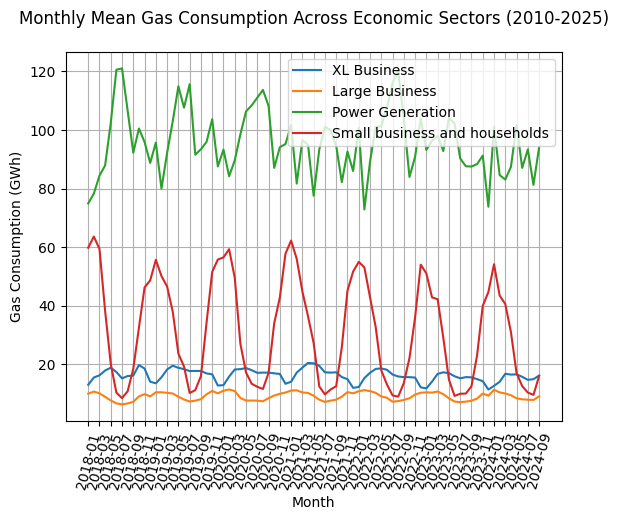

In [393]:
# Converting dates to a string format for better x-axis labeling
monthly_mean.index = monthly_mean.index.astype(str)

fig,ax =plt.subplots()
ax.plot(monthly_mean.index,monthly_mean['xl_business'], label='XL Business')
ax.plot(monthly_mean.index,monthly_mean['l_business'], label='Large Business')
ax.plot(monthly_mean.index,monthly_mean['power_gen'], label='Power Generation')
ax.plot(monthly_mean.index,monthly_mean['xs_business_houses'], label='Small business and households')
ax.set_xlabel("Month")
ax.set_ylabel("Gas Consumption (GWh)")
ax.grid()
ax.legend(loc='upper right')

# Display every second x-tick
ticks = np.arange(0, len(monthly_mean.index), 2)  # Every second index
ax.set_xticks(ticks)
ax.set_xticklabels(monthly_mean.index[ticks], rotation=75)

# `pad=20` increases the distance between the title and the plot
plt.title("Monthly Mean Gas Consumption Across Economic Sectors (2010-2025)", pad=20)
plt.show()

The correlation matrix revealed a positive correlation (0.78) between gas consumption trends in large businesses (**orange line**), extra small businesses, and households (**red line**). The plot above illustrates this pattern.

**High Variability in Small Business and Household Consumption:**
* Gas consumption for small businesses and households shows high variability.
* Demand increases during the winter months and decreases in summer.

**XL Business Consumption Patterns:**
* XL business gas consumption fluctuates minimally.
* Consumption drops in November and December and returns to normal by March.

**Large Business Consumption Patterns:**
* Large business gas consumption shows the opposite trend to XL businesses.
* Consumption peaks in December and January and then returns to normal.

**Fluctuations in Power Generation Consumption:**
* Gas consumption for power generation fluctuates significantly throughout the year.
* Peaks in summer months, while minimum levels are observed in winter.

## <a id='toc1_4_'></a>[Regression model](#toc0_)

### <a id='toc1_4_1_'></a>[Visualization of Polynomial Regression with Seaborn.](#toc0_)
Polynomial regression better demonstrates how gas consumption behaves over the years.

I will plot a polynomial regression for the data from the Power Generation sector using `sns.lmplot`.

Ref.:[seaborn.lmplot](https://seaborn.pydata.org/generated/seaborn.lmplot.html)

* Months - independent variable (X)
* Power gen. gas consumption- the dependent variable (y)

Ref.: [Copy of the DataFrame](https://www.w3schools.com/python/pandas/ref_df_copy.asp)

In [394]:
# Creating a new DF with Power Generation data
# Copy() helps to awoid warnings. 
# Any changes made in the original DataFrame will NOT be reflected in the copy.
power_g_data = data[['date','power_gen']].copy()

# Adding month and year columns
power_g_data['year'] = power_g_data['date'].dt.year
power_g_data['month'] = power_g_data['date'].dt.month

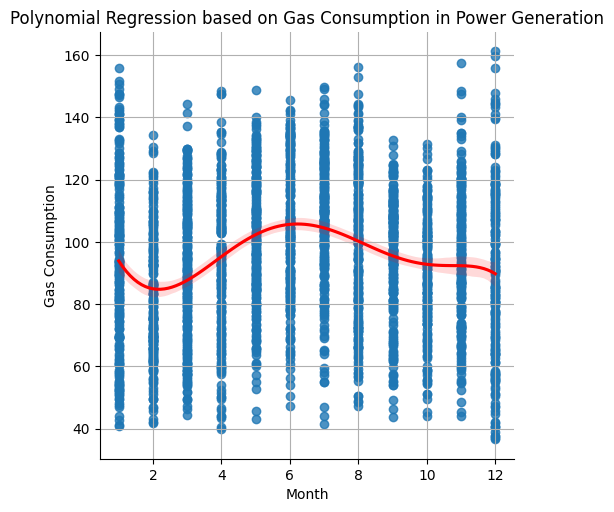

In [395]:
# Polynomial Regression for Gas Consumption in Power Generation
sns.lmplot(x='month', y='power_gen', data=power_g_data, order=6, line_kws={'color': 'red'})
plt.title('Polynomial Regression based on Gas Consumption in Power Generation')
plt.xlabel('Month')
plt.ylabel('Gas Consumption')
plt.grid(True)
plt.show()

The plot demonstrates a pattern where gas consumption peaks in June and reaches its lowest point in February.

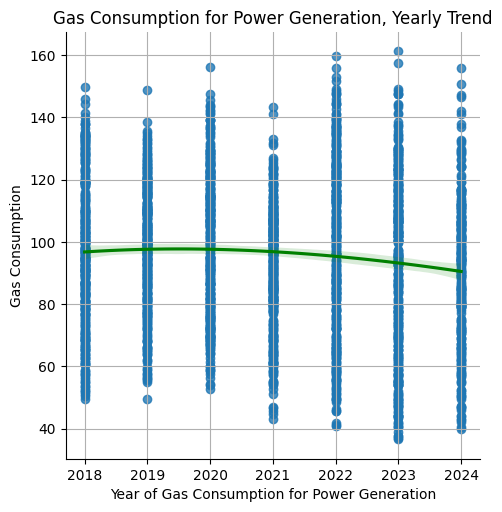

In [396]:
# Now the same for yearly trend
sns.lmplot(x='year', y='power_gen', data=power_g_data, order=3, line_kws={'color': 'green'})
plt.title('Gas Consumption for Power Generation, Yearly Trend')
plt.xlabel('Year of Gas Consumption for Power Generation')
plt.ylabel('Gas Consumption')
plt.grid(True)
plt.show()

According to the plot above, there is a trend of decreasing gas consumption in the Power Generation sector. The peak was in the years 2019-2020, and since then, a decreasing trend is clear.

### Modeling and Prediction

In [397]:
data.head() 

,date,l_business,xs_business_houses,xl_business,power_gen,total
0,2018-01-01,7.25,55.41,9.49,57.06,129.22
1,2018-01-02,9.54,57.61,10.58,54.86,132.58
2,2018-01-03,10.48,60.51,12.31,69.22,152.51
3,2018-01-04,10.58,59.12,13.31,96.65,179.66
4,2018-01-05,10.68,62.32,13.33,100.16,186.49


### Polynomial Regression for gas consumption of households.
#### Transform data to get the polynomial features.

I need two np.arrays with data.

In [398]:
dates = data['date']
# dates need to be converted into a numerical representation suitable for polynomial regression.
numerical_dates = (data['date'] - data['date'].min()).dt.days

consumption = data['xs_business_houses']

# A numerical value for the last day of observation. 
print(numerical_dates.max())
print(data['date'].max())


2464
2024-09-30 00:00:00


In [399]:
# Dates will be a predictor (input)

# I use .reshape() on X, because this array must be two-dimensional.
X = numerical_dates.to_numpy().reshape(-1, 1)

# Gas consumption will be a response (output)
Y = consumption.to_numpy()


In [400]:
X

array([[   0],
       [   1],
       [   2],
       ...,
       [2462],
       [2463],
       [2464]])

In [410]:
# Degree specifies the maximal degree of the polynomial features
degree = 4


poly = PolynomialFeatures(degree=degree)
x_poly = poly.fit_transform(X)

#### Use new polynomial features to train the Linear Regression model.

In [411]:
# Create an instance of the class LinearRegression, 
# Which will represent the regression model.
model = LinearRegression()

model.fit(x_poly,Y)

LinearRegression()

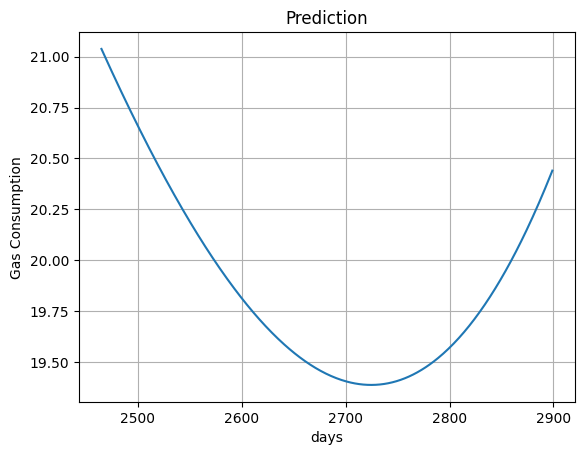

In [413]:
# prediction for 1 year starting from the last date:

satart_date = 2465
end_date = 2900
future_dates = np.arange(satart_date,end_date).reshape(-1, 1)

# Transform future dates to polynomial features
future_dates_poly = poly.fit_transform(future_dates)

# predictions
predictions = model.predict(future_dates_poly)

# Convert to pandas Series
predictions_series = pd.Series(predictions)

future_dates_reshaped = future_dates.reshape(-1, 1)
future_dates_series = pd.Series(future_dates.flatten())

# Making a dataFrame

prediction_data = pd.DataFrame({'date': future_dates_series,
                                'pred_gas_consumption': predictions_series})

# Plotting the prediction 
fig,ax =plt.subplots()
sns.lineplot(data=prediction_data, x='date', y='pred_gas_consumption')
plt.title('Prediction')
plt.xlabel('days')
plt.ylabel('Gas Consumption')
plt.grid(True)
plt.show()
